# DecMeg2014 - Decoding the Human Brain (Simple Example)

Ejemplo sencillo del proyecto.

En ese ejemplo se realizan los siguientes pasos:

    - Coger los archivos del 1 al 16 .mat.
    - Preprocesamiento: Coge todos los valores de las series (1.5s) y los normaliza mediante z-score
    - Realiza una separación de los datos con 80% para entrenar y 20% para validar.
    - Aplicación de una red LSTM sencilla.
    - Evaluación de la accuracy, matriz de confusión y curva ROC

### Documentación

Repositorio de Kaggle: 
 https://www.kaggle.com/c/decoding-the-human-brain

Repositorio de Github (Ejemplos de códigos en Matlab y Python):
https://github.com/FBK-NILab/DecMeg2014

### Importación de librerías

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt

## Red LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Coger los datos de los archivos .mat

#### Preprocesamiento: normalizarlos

Creamos una función "create_features" que se encargará de devolver los valores X. En esta función, se realiza todo el procesamiento de los datos. Los preprocesamiento que realiza son:

    1. Paso de la lista X de 3D a 2D. Poniendo como filas el primer elemento (las diferentes pruebas) y como columnas se hace un join del segundo elemento(series temporales o canales) y del tercer elemento(valores de cada serie temporal) (Este paso lo quitamos para realizar la clasificacion con LSTM, que como entrada las dimensiones deben ser 3D)
    
    2. Normalizamos los valores restandolos por la media y dividiéndolo por la desviación típica

In [2]:
def create_features(XX, tmin, tmax, sfreq, tmin_original=-0.5):
    """Creation of the feature space:
    - restricting the time window of MEG data to [tmin, tmax]sec.
    - Concatenating the 306 timeseries of each trial in one long
      vector.
    - Normalizing each feature independently (z-scoring).
    """
    """print("Applying the desired time window.")
    beginning = np.round((tmin - tmin_original) * sfreq).astype(np.int)
    end = np.round((tmax - tmin_original) * sfreq).astype(np.int)
    XX = XX[:, :, beginning:end].copy()"""

    #print("2D Reshaping: concatenating all 306 timeseries.")
    #XX = XX.reshape(XX.shape[0], XX.shape[1] * XX.shape[2])

    print("Features Normalization.")
    XX -= XX.mean(0)
    XX = np.nan_to_num(XX / XX.std(0))

    return XX

#### Coger todos los .mat en un array aplicando el preprocesado

Cogemos los datos de los ficheros train_subject13.mat, del 13 al 16. En esta etapa se realizan varios pasos:

    1. Creamos una lista X_train y y_train que contendrán todos los datos para realizar el entrenamiento. 
    
    2. Por cada uno de los ficheros, llamamos a la función create_features para que realice el correspondiente preprocesamiento de los datos.
    
    3. Una vez tenemos los datos del fichero, los agregamos a la lista.
    
    4. Una vez tenemos todas las listas en la lista, creamos un array realizando un join de las listas dentro de la lista. Para eso utilizamos la función vstack de la librería numpy

In [3]:
subjects_train = range(1, 17) # use range(13, 16) for all subjects
print("Training on subjects", subjects_train )

# We throw away all the MEG data outside the first 0.5sec from when
# the visual stimulus start:
tmin = 0.0
tmax = 0.500
print("Restricting MEG data to the interval [%s, %s]sec." % (tmin, tmax))

X_train = []
y_train = []
X_test = []
ids_test = []

print("Creating the trainset.")
for subject in subjects_train:
    filename = './data/data/train_subject%02d.mat' % subject
    print("Loading", filename)
    data = loadmat(filename, squeeze_me=True)
    XX = data['X']
    yy = data['y']
    sfreq = data['sfreq']
    tmin_original = data['tmin']
    print("Dataset summary:")
    print("XX:", XX.shape)
    print("yy:", yy.shape)
    print("sfreq:", sfreq)

    XX = create_features(XX, tmin, tmax, sfreq)
    
    print("XX (Preprocessed): ", XX.shape)

    X_train.append(XX)
    y_train.append(yy)
    
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
print("Trainset:", X_train.shape)

Training on subjects range(1, 17)
Restricting MEG data to the interval [0.0, 0.5]sec.
Creating the trainset.
Loading ./data/data/train_subject01.mat
Dataset summary:
XX: (594, 306, 375)
yy: (594,)
sfreq: 250.0
Features Normalization.
XX (Preprocessed):  (594, 306, 375)
Loading ./data/data/train_subject02.mat


KeyboardInterrupt: 

### Separación de archivos train/test

In [6]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_train,y_train,test_size=0.2)
print("X_train_new: ",X_train_new.shape)
print("y_train_new: ",y_train_new.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)
print(y_test)

X_train_new:  (7531, 306, 375)
y_train_new:  (7531,)
X_test:  (1883, 306, 375)
y_test:  (1883,)
[1 1 0 ... 1 0 1]


### Red LSTM

#### Creación de la red

Para crear la red LSTM vamos a utilizar la librería de keras. En concreto, crearemos un modelo secuencial que contenga como modelo de entrada una red recursiva (Red LSTM).

El primer paso será la creación de la red. En este paso, creamos una instancia de modelo secuencial, y agregamos los modelos que queramos. En este caso, agregamos una red LSTM pasándole como parámetros el número de parámetros o nodos que tendrá la salida (3) y las dimensiones que tendrá los parámetros de entrada (en este parámetro debemos especificar el tamaño de las columnas: 306, 375). Hay que destacar que los tamaños de los parámetros de entrada (input_shape) sólo se le debe pasar al primer modelo y dichas dimensiones deben ser 3D.

Como segundo modelo le pasamos el modelo Dense.

Tras crear el modelo, lo compilamos antes de empezar a entrenarlo. En ese paso hay que especificar 3 parámetros (Estos parámetros podemos ir variándolos para ir probando):

    - Opimizador
    
    - Función de pérdida
    
    - Lista de métricas
    
El último paso es entrenar el modelo, para ello se le pasa los datos de entrenamiento y las etiquetas. En este ejemplo, también se le pasa datos de test para que entrene mediante validación. A parte de estos parámetros, se especifica el número de épocas en 7 (cada época corresponde una iteración de entrenamiento).

In [2]:
# Creación de la red
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(3, input_shape=(306, 375)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compilación de la red
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento de la red
model.fit(X_train_new,y_train_new, validation_data=(X_test,y_test), epochs=7, batch_size=100)

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

#### Predicciones

En este paso realizamos una predicción de los datos. Hay que tener en cuenta que el modelo devuelve como predicción valores float entre 0 y 1. Por lo que los pasamos a 0 y 1 dependiendo si su valor es mayor de 0.5 o no

/home/isa/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/keras/engine/sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


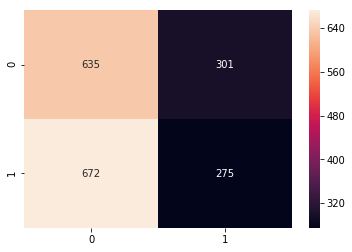

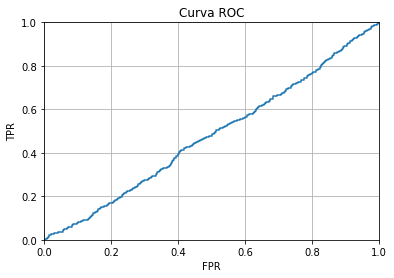

In [7]:
def convert(x):
    result = []
    for i in range(len(x)):
        if x[i] < 0.5:
            result.append(0)
        else:
            result.append(1)
    return result
# Predecimos a partir de los datos de test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_pred = convert(y_pred)
#print(y_proba)

fprs,tprs,thresholds = metrics.roc_curve(y_test,y_proba)

# Evaluación
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True, fmt="d")
plt.show()

plt.plot(fprs, tprs)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()